# Model 000 Basic: Coupled Steady-State Solution

This model shows example usage of the Basic model from the TerrainBento package.

This uses has stream power and linear diffusion and has the following governing equation:

$\frac{\partial \eta}{\partial t} = - KA^{1/2}S + D\nabla^2 \eta$

Refer to [REF MANUSCRIPT] for the definition of all symbols. 

This notebook (a) shows the initialization and running of this model, (b) saves a NetCDF file of the topography, which we will use to make an oblique Paraview image of the landscape, and (c) creates a slope-area plot at steady state.

In [15]:
# import required modules
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
%matplotlib inline

from landlab import imshow_grid
from landlab.io.netcdf import write_netcdf

from terrainbento import Basic

In [24]:
# create the parameter dictionary needed to instantiate the model 
# all parameters used are specified in this notebook block

params = {# these three parameters are required by all models
          'dt' : 100, # years
          'output_interval': 1e6, # years
          'run_duration': 1e6, # years
          # these parameters are needed to specify the details of the model grid
          'number_of_node_rows' : 100,
          'number_of_node_columns' : 160,
          'node_spacing' : 10.0, # meters  
          "add_random_noise": True, 
          "initial_noise_std": 1.,
          'random_seed': 4897, # set to initialize the topography with reproducible random noise
          # these parameter control geomorphic processes
          'water_erodability' : 0.001, # years^-1
          'm_sp' : 0.5, # unitless
          'n_sp' : 1.0, # unitless
          'regolith_transport_parameter' : 0.2, # meters^2/year
          # these parameters control model boundary conditions
          "BoundaryHandlers": "NotCoreNodeBaselevelHandler",
          "NotCoreNodeBaselevelHandler": {"modify_core_nodes": True, "lowering_rate": -0.0005} , # meters/year
          # these parameter control how model output is written
          'save_first_timestep': False,
          'output_filename': 'model_000_output',
         }

In [ ]:
# initialize the model by passing the parameter dictionary
model = Basic(params=params)

# to run the model as specified by the parameters we would execute the following line:
# model.run()


In [19]:
# However, here we want to to run until steady state based on a tolerance. 
# With the original (160x100) grid and parameter values it will take around
# 1 million years to reach steady state. 

# set a tolerance for determining steady state
tolerance = 0.0001

# set dt and initialize the elapsed_time variable
dt = params['dt']
elapsed_time = 0 

# initialize a variable to identify if steady state has been reached
keep_running = True

# run the model until stead state has been reached. 
while keep_running == True:
    
    # save the pre-model-step topography of the core nodes to assess steady state. 
    pre_topo = model.grid.at_node['topographic__elevation'][model.grid.core_nodes]
    
    # run the model one step
    model.run_one_step(dt)
    
    # save the post-model step topography of the core nodes to assess steady state. 
    post_topo = model.grid.at_node['topographic__elevation'][model.grid.core_nodes]
    
    # increment elapsed time
    elapsed_time += dt
    
    # assess if steady state has been reached. 
    if max(abs(pre_topo - post_topo)) <= tolerance: # 1 mm
        keep_running = False
    
    # if time rounds to 10,000 years, print out a log message. 
    if elapsed_time % 10000 == 0:
        print('Elapsed time: ', elapsed_time)
        print('Maximum Topographic Change/Tolerance: ', np.round(max(abs(pre_topo - post_topo))/tolerance, decimals=2))       

Elapsed time:  10000
Maximum Topographic Change/Tolerance:  1234.23
Elapsed time:  20000
Maximum Topographic Change/Tolerance:  653.63
Elapsed time:  30000
Maximum Topographic Change/Tolerance:  123.12
Elapsed time:  40000
Maximum Topographic Change/Tolerance:  208.28
Elapsed time:  50000
Maximum Topographic Change/Tolerance:  134.48
Elapsed time:  60000
Maximum Topographic Change/Tolerance:  28.59
Elapsed time:  70000
Maximum Topographic Change/Tolerance:  3.58


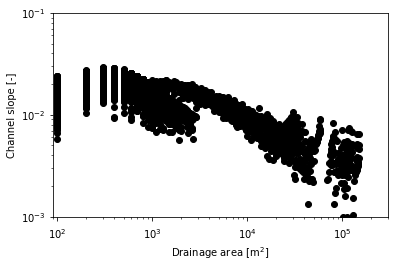

In [20]:
# MAKE SLOPE-AREA PLOT

# plot nodes that are not on the boundary or adjacent to it
plotting_nodes = ((model.grid.node_x > params['node_spacing'])&
                  (model.grid.node_x < params['node_spacing']*(params['number_of_node_columns']-2))&
                  (model.grid.node_y > params['node_spacing'])&
                  (model.grid.node_y < params['node_spacing']*(params['number_of_node_rows']-2)))

# assign area_array and slope_array
area_array = model.grid.at_node['drainage_area'][plotting_nodes]
slope_array = model.grid.at_node['topographic__steepest_slope'][plotting_nodes]

# instantiate figure and plot
fig = plt.figure(figsize=(6, 3.75))
slope_area = plt.subplot()

# plot the data
slope_area.scatter(area_array, slope_array, marker='o', c='k', 
                   label = 'Model Basic') 
                   
# make axes log and set limits
slope_area.set_xscale('log')
slope_area.set_yscale('log')
slope_area.set_xlim(9*10**1, 3*10**5)
slope_area.set_ylim(1e-3, 1e-1)

# set x and y labels
slope_area.set_xlabel(r'Drainage area [m$^2$]')
slope_area.set_ylabel('Channel slope [-]')

slope_area.legend(scatterpoints=1,prop={'size':12})
slope_area.tick_params(axis='x', which='major', pad=7)

# save out an output figure
output_figure = os.path.join('output_figures/maintext_basic_streampower_slope_area_rev1.eps')
fig.savefig(output_figure, bbox_inches='tight', dpi=1000) # save figure

In [ ]:
#export a NetCDF of the final topography for Paraview to use.
output_file = os.path.join('output_netcdfs/maintext_basic_stream_power_rev1.nc')
write_netcdf(output_file, model.grid, format='NETCDF3_64BIT', names='topographic__elevation')

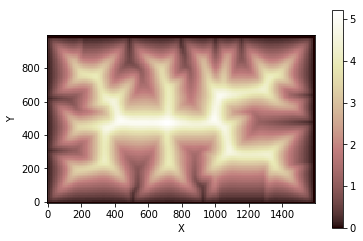

In [21]:
# make a plot of the final steady state topography
imshow_grid(model.grid, 'topographic__elevation')